In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('sms_spam_collection.csv')
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [4]:
df.shape

(5572, 2)

In [5]:
df.describe(include='all')

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
df.isnull().sum()

label      0
message    0
dtype: int64

In [7]:
df.duplicated().sum()

403

In [8]:
df= df.drop_duplicates()
df.duplicated().sum()

0

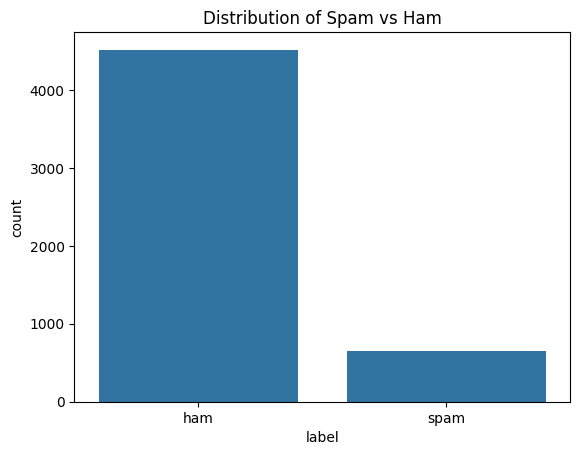

In [9]:
sns.countplot(x='label', data=df)
plt.title('Distribution of Spam vs Ham')
plt.show()

In [10]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [11]:
import re
import string
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()                              # Lowercase
    text = re.sub(r'\d+', '', text)                  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

df['cleaned_message'] = df['message'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aneet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
df['msg_length'] = df['message'].apply(len)
df['word_count'] = df['message'].apply(lambda x: len(x.split()))
df['num_digits'] = df['message'].apply(lambda x: sum(c.isdigit() for c in x))
df['num_links'] = df['message'].apply(lambda x: x.lower().count('http'))
df['num_special_chars'] = df['message'].apply(lambda x: sum(c in "!@#$%^&*()" for c in x))
df.head()

,label,message,cleaned_message,msg_length,word_count,num_digits,num_links,num_special_chars
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,111,20,0,0,0
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,29,6,0,0,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...,155,28,25,0,3
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say,49,11,0,0,0
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though,61,13,0,0,0


In [13]:
df['num_links'].value_counts()

num_links
0    5148
1      21
Name: count, dtype: int64

In [14]:
df.head()

,label,message,cleaned_message,msg_length,word_count,num_digits,num_links,num_special_chars
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,111,20,0,0,0
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,29,6,0,0,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...,155,28,25,0,3
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say,49,11,0,0,0
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though,61,13,0,0,0


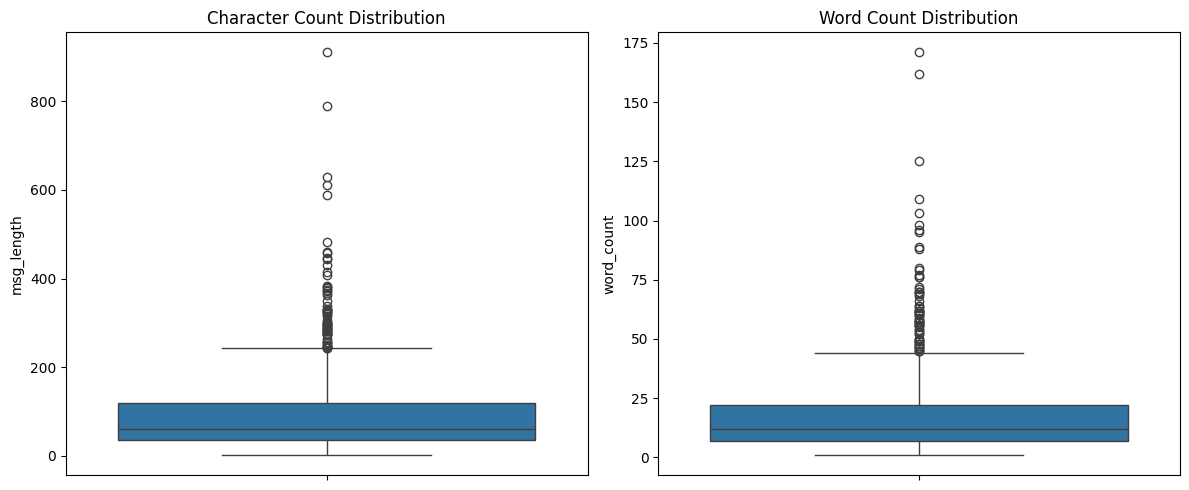

In [15]:

# Boxplots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['msg_length'])
plt.title('Character Count Distribution')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['word_count'])
plt.title('Word Count Distribution')

plt.tight_layout()
plt.show()


In [16]:
# Define a function to detect outliers using IQR
def iqr_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Get bounds for character and word count
char_lower, char_upper = iqr_bounds(df['msg_length'])
word_lower, word_upper = iqr_bounds(df['word_count'])


In [17]:
# Filter the dataset
df_filtered = df[(df['msg_length'] >= char_lower) & (df['msg_length'] <= char_upper) &
                 (df['word_count'] >= word_lower) & (df['word_count'] <= word_upper)]

print("Original dataset size:", df.shape)
print("Filtered dataset size:", df_filtered.shape)

Original dataset size: (5169, 8)
Filtered dataset size: (5095, 8)


In [18]:
df.select_dtypes(include=[np.number]).skew().sort_values(ascending=True)

label                 2.250180
msg_length            2.593843
word_count            2.723897
num_digits            3.169761
num_special_chars    11.474206
num_links            15.597696
dtype: float64

In [19]:
# Apply log1p to reduce skewness
skewed_cols = ['msg_length','word_count', 'num_digits', 'num_special_chars', 'num_links']
df[skewed_cols] = df[skewed_cols].apply(lambda x: np.log1p(x))


In [20]:
df[skewed_cols].skew()

msg_length           -0.068797
word_count            0.013731
num_digits            2.065739
num_special_chars     1.596755
num_links            15.597696
dtype: float64

In [21]:
from scipy.stats import boxcox

boxcox_cols = ['num_digits', 'num_special_chars']

# Apply Box-Cox transformation (only if all values > 0)
for col in boxcox_cols:
    # Shift if minimum is zero or less
    if (df[col] <= 0).any():
        df[col] = df[col] + 1e-6  # small positive shift

    df[col], _ = boxcox(df[col])


In [22]:
df[skewed_cols].skew()

msg_length           -0.068797
word_count            0.013731
num_digits            1.113125
num_special_chars     0.865920
num_links            15.597696
dtype: float64

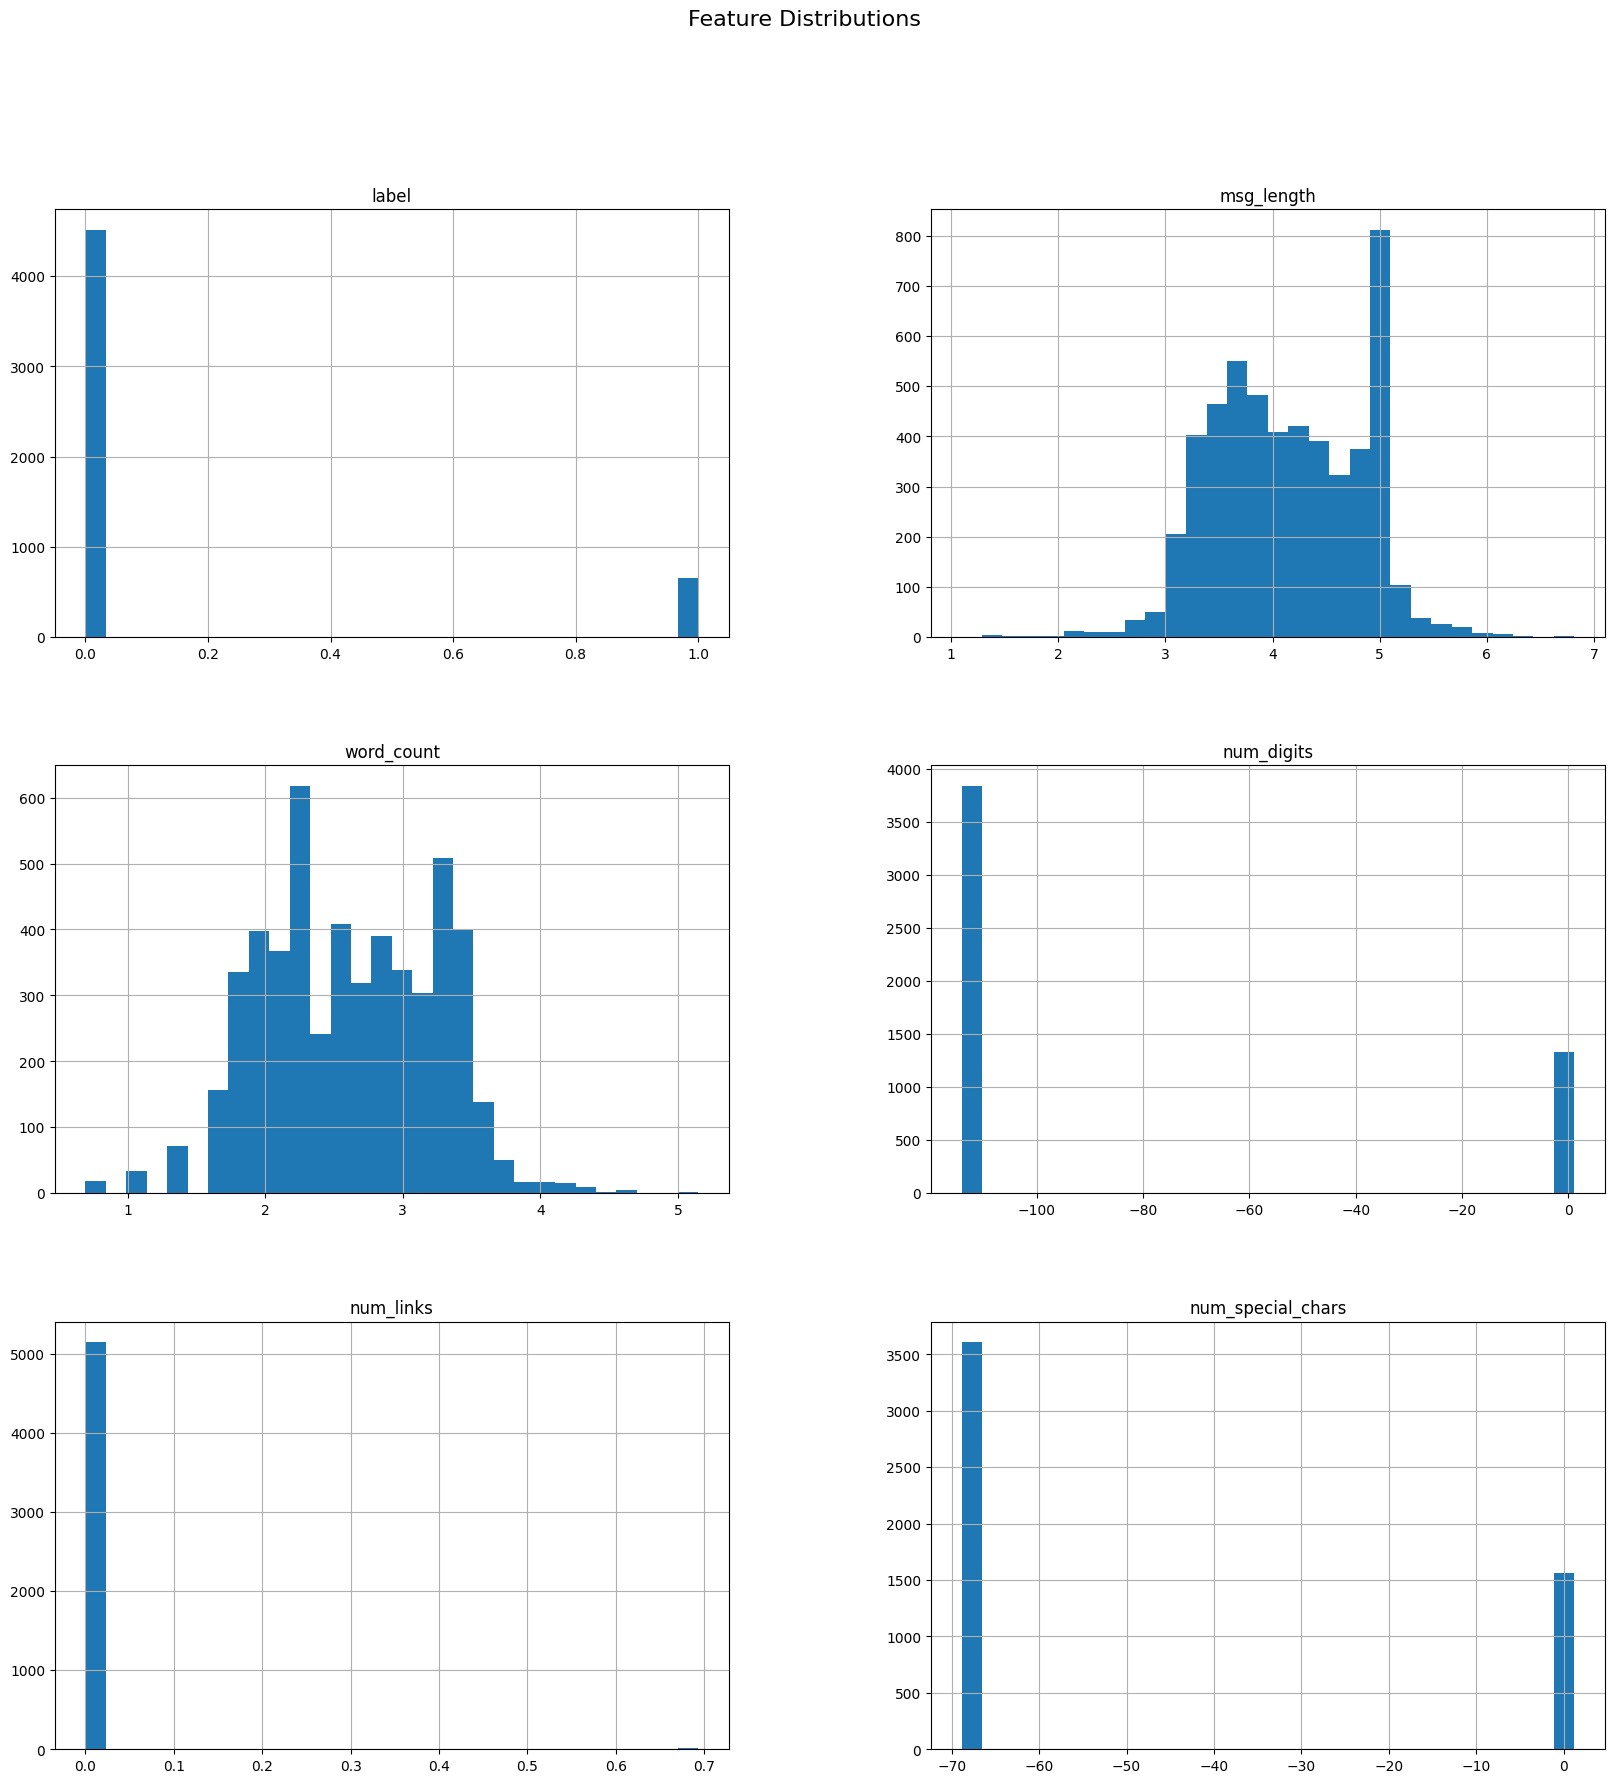

In [23]:
df.hist(figsize=(20, 20), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

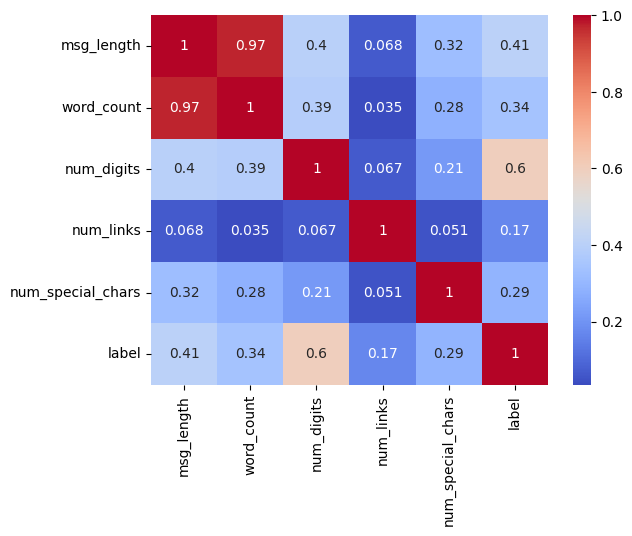

In [24]:

sns.heatmap(df[['msg_length', 'word_count', 'num_digits', 'num_links', 'num_special_chars', 'label']].corr(), annot=True, cmap='coolwarm')
plt.show()


In [25]:
df.drop(columns=['word_count'],inplace=True)

In [26]:
from sklearn.model_selection import train_test_split
feature_cols = ['msg_length', 'num_digits', 'num_special_chars', 'num_links']
X= df[feature_cols]
y= df['label']


In [27]:
y.value_counts()

label
0    4516
1     653
Name: count, dtype: int64

In [28]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

print("\nShapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)



Shapes:
X_train: (4135, 4)
y_train: (4135,)
X_test: (1034, 4)
y_test: (1034,)


In [29]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Check new class balance
print(y_train.value_counts(normalize=True))


label
0    0.5
1    0.5
Name: proportion, dtype: float64


In [31]:
from sklearn.preprocessing import MinMaxScaler
# Scale the data
scalar = MinMaxScaler()
X_train_scaled = pd.DataFrame(scalar.fit_transform(X_train), columns=X_train.columns)
X_test_scaled= pd.DataFrame(scalar.fit_transform(X_test), columns=X_test.columns)

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

models = {
    "Logistic Regression": LogisticRegression(
        penalty='l2', 
        C=0.05,  # stronger regularization
        class_weight='balanced', 
        solver='liblinear', 
        random_state=42
    ),
    
    "SVC": SVC(
        kernel='linear', 
        C=0.05,  # stronger regularization
        class_weight='balanced', 
        probability=True, 
        random_state=42
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=100, 
        max_depth=3,  # shallower trees to reduce overfitting
        min_samples_split=5,
        class_weight='balanced', max_features='sqrt',
        random_state=42
    ),

    "Gradient Boosting": GradientBoostingClassifier(
        learning_rate=0.02,  # slower learning to avoid overfitting
        max_depth=3, 
        n_estimators=100, 
        subsample=0.8,  # random sampling of rows to reduce variance
        random_state=42
    ),


    "Decision Tree": DecisionTreeClassifier(
        max_depth=3,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    )
}

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    print(f"\nModel:{name}")
    print("Train Accuracy:", accuracy_score(y_train,y_train_pred))
    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Precison:", precision_score(y_test,y_test_pred))
    print("Recall:", recall_score(y_test,y_test_pred))
    print("F1 Score:", f1_score(y_test,y_test_pred))



Model:Logistic Regression
Train Accuracy: 0.8877663991143094
Test Accuracy: 0.8723404255319149
Precison: 0.49800796812749004
Recall: 0.9541984732824428
F1 Score: 0.6544502617801047

Model:SVC
Train Accuracy: 0.8915029061721561
Test Accuracy: 0.8733075435203095
Precison: 0.5
Recall: 0.9618320610687023
F1 Score: 0.6579634464751958

Model:Random Forest
Train Accuracy: 0.9496263492942153
Test Accuracy: 0.9313346228239845
Precison: 0.6595744680851063
Recall: 0.9465648854961832
F1 Score: 0.7774294670846394

Model:Gradient Boosting
Train Accuracy: 0.9564074176584556
Test Accuracy: 0.902321083172147
Precison: 0.5675675675675675
Recall: 0.9618320610687023
F1 Score: 0.7138810198300283

Model:Decision Tree
Train Accuracy: 0.9510102407971215
Test Accuracy: 0.9526112185686654
Precison: 0.7469879518072289
Recall: 0.9465648854961832
F1 Score: 0.835016835016835


In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

dt_params = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

dt_model = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(dt_model, dt_params, cv=5, scoring='f1', n_jobs=-1)
grid_dt.fit(X_train_scaled, y_train)

print("Best Decision Tree Params:", grid_dt.best_params_)
print("Best F1 Score (Train CV):", grid_dt.best_score_)


Best Decision Tree Params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best F1 Score (Train CV): 0.9558540337875103


In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred_dt = grid_dt.predict(X_test_scaled) 
# Decision Tree Evaluation
print("\n===== Decision Tree Evaluation =====")
print("Train Accuracy:", accuracy_score(y_train, grid_dt.predict(X_train_scaled)))
print("Test Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))




===== Decision Tree Evaluation =====
Train Accuracy: 0.9608358704677553
Test Accuracy: 0.8858800773694391
Precision: 0.5323383084577115
Recall: 0.816793893129771
F1 Score: 0.6445783132530121

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.93       903
           1       0.53      0.82      0.64       131

    accuracy                           0.89      1034
   macro avg       0.75      0.86      0.79      1034
weighted avg       0.92      0.89      0.90      1034



In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Initialize the RandomForest model
rf = RandomForestClassifier(random_state=42)

# Define hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Apply GridSearchCV for tuning the Random Forest model
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, verbose=2, n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)

# Best hyperparameters
print("Best Parameters:", grid_rf.best_params_)

# Use the best model from GridSearchCV
best_rf = grid_rf.best_estimator_

# Predictions with the best Random Forest model
y_pred_rf = best_rf.predict(X_test_scaled)

# Random Forest Evaluation
print("\n===== Random Forest Evaluation =====")
print("Train Accuracy:", accuracy_score(y_train, best_rf.predict(X_train_scaled)))
print("Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

===== Random Forest Evaluation =====
Train Accuracy: 0.9894824245779131
Test Accuracy: 0.8326885880077369
Precision: 0.4233576642335766
Recall: 0.8854961832061069
F1 Score: 0.5728395061728395

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90       903
           1       0.42      0.89      0.57       131

    accuracy                           0.83      1034
   macro avg       0.70      0.86      0.73      1034
weighted avg       0.91      0.83      0.86      1034



In [43]:
import joblib

# Save the best decision tree model
joblib.dump(grid_rf, 'best_decision_tree_model.joblib')

print("Model saved as 'best_decision_tree_model.joblib'")


Model saved as 'best_decision_tree_model.joblib'


In [45]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
# Define the pipeline with preprocessing and model
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),  
    'vectorizer', TfidfVectorizer()
    ('model', grid_rf)  
])

In [47]:
pipeline.fit(X_train_scaled.values,y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=RandomForestClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'max_depth': [None, 10, 20, 30],
                                          'max_features': ['sqrt', 'log2'],
                                          'min_samples_leaf': [1, 2, 4],
                                          'min_samples_split': [2, 5, 10],
                                          'n_estimators': [50, 100, 150, 200]},
                              verbose=2))])

In [49]:
#save Pipeline
joblib.dump(pipeline,"SMS_Classification_Pipeline.joblib")

['SMS_Classification_Pipeline.joblib']

In [51]:
load_pipeline = joblib.load("SMS_Classification_Pipeline.joblib")

In [91]:
# Specify the selected feature columns
selected_columns = ['msg_length', 'num_digits', 'num_special_chars', 'num_links']

# Select 25 random indices
random_indices = np.random.choice(X.shape[0], 25, replace=False)

# Select the random rows from X and y
X_random = X.iloc[random_indices]
y_random = y.iloc[random_indices]

# Ensure the transformed features have the correct column names
X_random_df = pd.DataFrame(X_random, columns=selected_columns, index=X_random.index)

X_random_array = X_random_df.values

# Make predictions using the loaded pipeline
predicted = load_pipeline.predict(X_random_array)


# Combine the features with actual and predicted labels
X_random_display = X_random_df.copy()  # Keep the original selected features
X_random_display["Actual"] = y_random.values
X_random_display["Predicted"] = predicted

# Map class labels to meaningful text
X_random_display["Actual"] = X_random_display["Actual"].map({0: "ham", 1: "spam"})
X_random_display["Predicted"] = X_random_display["Predicted"].map({0: "ham", 1: "spam"})

# Save the results to CSV
X_random_display.to_csv("unseen_data_predictions_with_features.csv", index=False)

# Display the results
print("\nUnseen Data Predictions with Features:")
print(X_random_display.head(25))



Unseen Data Predictions with Features:
      msg_length  num_digits  num_special_chars  num_links Actual Predicted
603     3.663562 -114.189048         -68.882258        0.0    ham       ham
5004    5.117994    1.007953          -0.379734        0.0   spam      spam
2386    5.087596    0.935490          -0.379734        0.0   spam       ham
133     3.258097 -114.189048         -68.882258        0.0    ham       ham
1202    3.044522 -114.189048         -68.882258        0.0    ham       ham
4555    4.007333 -114.189048         -68.882258        0.0    ham       ham
2625    3.332205 -114.189048           0.316590        0.0    ham       ham
2187    4.653960 -114.189048         -68.882258        0.0    ham       ham
1659    4.990433    1.097291           0.316590        0.0   spam      spam
1049    4.356709   -0.383338          -0.379734        0.0    ham       ham
2580    3.850148 -114.189048         -68.882258        0.0    ham       ham
149     3.526361 -114.189048         -68.882258 